# Prepare Dataset

Load the "Iris" data set from the file and display its summary.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('data/iris.csv')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


We will use the "species" column as a prediction target, and "sepal_length", "sepal_width", "petal_length" and "petal_width" columns as input features. All of these features are numeric.

In [2]:
numeric_features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'species'

Filter dataset by creating **X** and **y**, where **X** combines feature columns and **y** represents the target column. 

In [4]:

X = df[numeric_features]
y = df[target]

print('X columns types:')
print('-'*20)
print(X.dtypes)

print()

print('y column type:')
print('-'*20)
print(y.dtypes)

X columns types:
--------------------
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
dtype: object

y column type:
--------------------
object


# Train SKLearn Model

Define transformers for the numeric and categorical features. Then we wrap them into columns transformation objects. 

Define a Random Forest for the classifier for the prediction of surviving passengers.

Define an ML model which represented by the pipeline that combines a data preprocessor and classification algorithm.

In [5]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', XGBClassifier(n_estimators=3, random_state=42))
])

Split dataset on training and test.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Train a new model.

In [7]:
model.fit(X_train, y_train)
print('Model has been successfully trained')

[21:17:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model has been successfully trained


/home/mykola/Projects/onnx-hello-world/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Score the model using test data.

In [8]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
y_probas = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('The model accuracy: %.2f' % accuracy)

The model accuracy: 1.00


# Convert Model To ONNX

Define a function for converting Dataframe to ONNX schema.

In [9]:
from skl2onnx.common.data_types import Int64TensorType, FloatTensorType, StringTensorType

def convert_to_onnx_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = Int64TensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else: # v == object
            t = StringTensorType([None, 1])
        inputs.append((k,t))
    return inputs

Convert and save the model into ONNX format.

In [12]:
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes  # noqa
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost  # noqa

initial_type = convert_to_onnx_schema(X)
print('The ONNX input schema:', initial_type)

update_registered_converter(
    XGBClassifier, 'XGBoostXGBClassifier',
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={'nocl': [True, False], 'zipmap': [True, False, 'columns']})


onnx_filename = 'iris.onnx'
onnx_model = convert_sklearn(model, initial_types=initial_type)
with open(onnx_filename, "wb") as f:
    f.write(onnx_model.SerializeToString())
    print('The model has been successfully saved in %s;' % onnx_filename)

The ONNX input schema: [('sepal_length', FloatTensorType(shape=[None, 1])), ('sepal_width', FloatTensorType(shape=[None, 1])), ('petal_length', FloatTensorType(shape=[None, 1])), ('petal_width', FloatTensorType(shape=[None, 1]))]
The model has been successfully saved in iris.onnx;


Score ONNX model using the test data.

In [11]:
def convert_to_onnx_inputs(df):
    inputs = {c: df[c].values for c in df.columns}
    for c in numeric_features:
        inputs[c] = inputs[c].astype(np.float32)
    for k in inputs:
        inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))
    return inputs


In [13]:
import onnxruntime as rt

onnx_inputs = convert_to_onnx_inputs(X_test)

sess = rt.InferenceSession(onnx_filename)
y_onnx_pred, y_onnx_probas = sess.run(None, onnx_inputs)
onnx_accuracy = accuracy_score(y_test, y_onnx_pred)
print('The ONNX model accuracy: %.2f' % onnx_accuracy)

The ONNX model accuracy: 1.00


In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_onnx_pred)
cm

array([[19,  0,  0],
       [ 0, 15,  0],
       [ 0,  0, 16]])

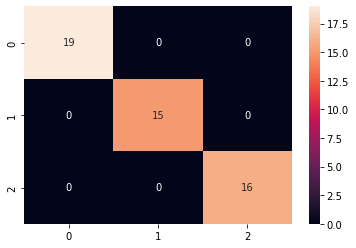

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(3), range(3))
sn.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [19]:
df_onnx_probas

,setosa,versicolor,virginica
0,0.151753,0.695901,0.152346
1,0.695822,0.153792,0.150386
2,0.151293,0.155928,0.692779
3,0.151753,0.695901,0.152346
4,0.128184,0.587820,0.283995
5,0.695822,0.153792,0.150386
6,0.151753,0.695901,0.152346
7,0.151293,0.155928,0.692779
8,0.151753,0.695901,0.152346
9,0.151753,0.695901,0.152346


<AxesSubplot:>

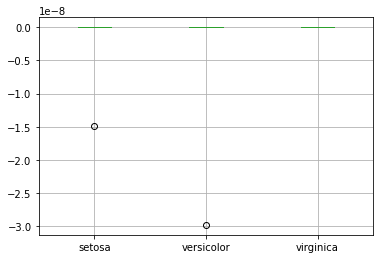

In [27]:
df_probas = pd.DataFrame(y_probas, columns=['setosa', 'versicolor','virginica'])
df_onnx_probas = pd.DataFrame(y_onnx_probas, columns=['setosa', 'versicolor','virginica'])

df_diff = df_probas - df_onnx_probas
df_diff.describe()
df_diff.boxplot()


(-0.5, 2686.5, 3587.5, -0.5)

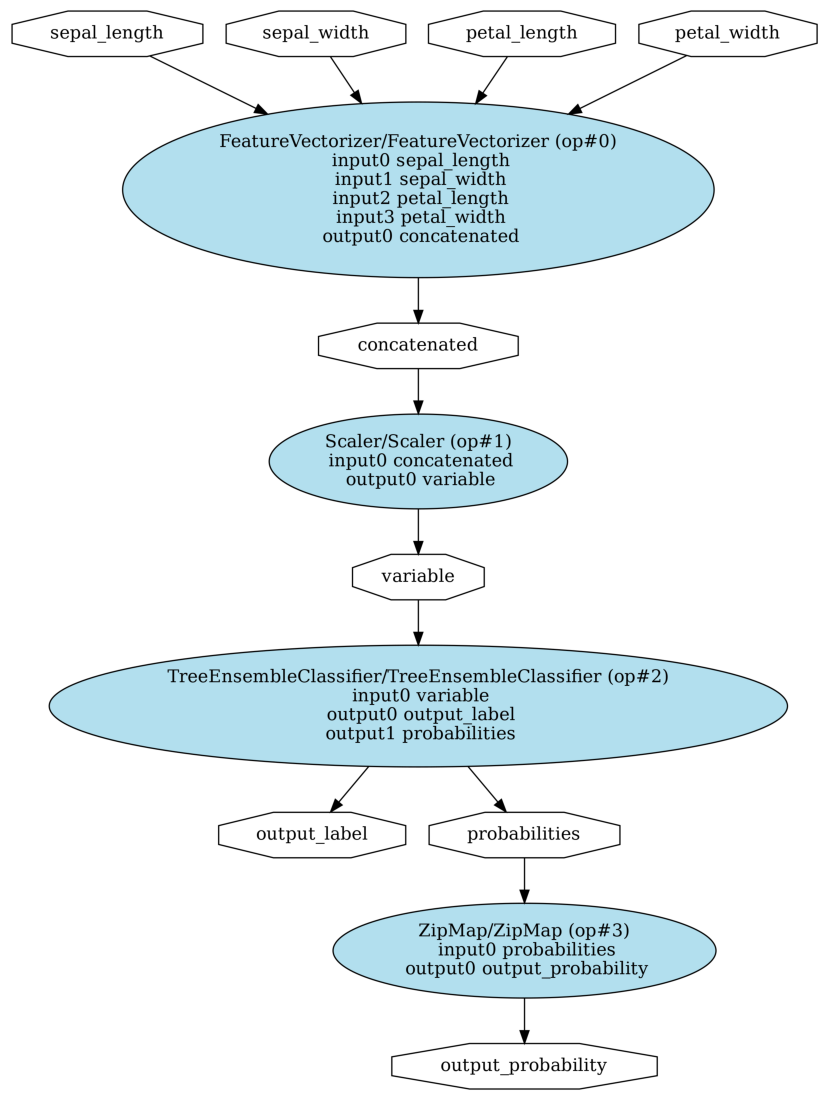

In [28]:
import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

pydot_graph = GetPydotGraph(onnx_model.graph, name=onnx_model.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="black",
                                                            fillcolor="lightblue2",
                                                            style="filled"))
pydot_graph.write_dot("pipeline_iris.dot")

os.system('dot -O -Gdpi=300 -Tpng pipeline_iris.dot')

image = plt.imread("pipeline_iris.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')